# Lab 3 Exploration: Customer Churn 

## Objectives

**The purpose of this lab is to help you gain experience preparing data, fitting a logistic regression model, and evaluating the model's performance.**  

In this lab you will:

* Explore a synthetic [**customer churn**](https://en.wikipedia.org/wiki/Customer_attrition) dataset.
* Gain additional experience with an expanding data science tool kit including:
  * Jupyter Notebook
  * Python3
  * Pandas
  * Matplotlib
  * [NumPy](https://numpy.org/)
  * and [**sklearn**](https://scikit-learn.org/stable/).
* Learn to model data in Python using **logistic regression**.
* Learn how to obtain the **probability of an outcome** from a logistic regression model.
* Learn to **evaluate a classification learning model** in Python with the help of:
  * **test set**,
  * metrics such as **accuracy score**, **precision**, **recall**, and **F1 score** for the two classes, 
  * **confusion matrix**, and
  * **receiver-operating characteristic (ROC) curve** and **AUC score**.
  




Gabriel Eze   

Porter Kelly  

DSC 340 S25

Lab 3: Customer Churn 

In [1]:
# Import any Python packages that you need here.
# All import statements should be in your first code cell. 
import pandas as pd
from math import sin, asin
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay, roc_auc_score




## Exploratory Data Analysis

**[Visit Kaggle to read the description and download the TelCo Customer Church dataset:](https://www.kaggle.com/blastchar/telco-customer-churn)**



Download and read file in.

In [2]:
f_file = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')


**Explore the dataset carefully.**



Check for duplicates, missing values; use a Kernel Density Estimate plot from the seaborn package to analyze feature distributions.

In [ ]:
print(f_file.duplicated().value_counts())
# f_file.info()
# f_file.isna().sum()
# f_file['TotalCharges'].

# plt.figure(figsize=(10, 6))  # Set figure size
# sns.kdeplot(f_file['SeniorCitizen'], shade=True, color='blue')  # Kernel Density Estimate (KDE) plot
# plt.title('Distribution of SeniorCitizen')  # Add title
# plt.xlabel('SeniorCitizen')  # X-axis label
# plt.ylabel('Density')  # Y-axis label
# plt.show()

## Prepare Data for Model Building

**Clean the data, encode it, and take whatever other steps are necessary for modeling building.**



The only occurrence of problematic data is under the TotalCharges column where there is precisely 11 cells with string quotes stored in. This results in the data type for the column assigned as "object". To fix this, replace these quotes with a median TotalCharges value before encoding the whole dataset since the median is moderately robust to outliers.

In [3]:



f_file_clean = f_file.copy()

# Convert 'TotalCharges' to numeric, coercing errors to NaN
f_file_clean['TotalCharges'] = pd.to_numeric(f_file_clean['TotalCharges'], errors='coerce')


# Impute on NAN cells with median Series aggregated by Contract catergory with respect to original DF indexing
f_file_clean['TotalCharges']  = f_file_clean.groupby('Contract')['TotalCharges'].transform(lambda x: x.fillna(x.median()))




# Prepare for encoding
f_file_clean = f_file_clean.drop(columns=['customerID'])

# Label encode binary categorical columns
for col in f_file_clean.select_dtypes(include='object').columns:
    if f_file_clean[col].nunique() == 2:
        f_file_clean[col] = LabelEncoder().fit_transform(f_file_clean[col])

# One-hot encode the remaining categorical columns
f_file_clean = pd.get_dummies(f_file_clean, drop_first=True)
# print(f_file_clean.isna().sum())


To translate customer spending habits better since logistic regression struggles with handling missing values, impute the median total charges categorized by the Contract feature. After imputing, I proceeded to encode the binary categorical features so as to avoid the binary quantitative features, then I applied one-hot encoding on the remaining features.

**Perform train-test split to partition your data into a training (80%) and test set (20%). Use stratified sampling to make sure each set contains a proportional number of customers who stay or leave the company.**

Select all columns as features except the target variable. Set a fixed random state on the train-test split for reproducibility.

In [4]:
# Collect variables
X = f_file_clean.drop(columns = ['Churn']) # Feature variables
y = f_file_clean['Churn'] # Target variable

# Perform stratified train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



**Scale your data using an appropriate feature-scaling method.**



Standardize the train set to follow a standard normal distribution using scikit-learn’s StandardScaler class.

In [5]:

scaler = StandardScaler()  # Initialize scaler function

scaler.fit(X_train) # Compute mean and stardard deviation

# Transform feature data using scaler scaled on the train set only

X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

## Fit a Logistic Regression Model

**Fit a logistic regression model to your training set.**



Avoid interacting with the test set. Instead, use the scaled train data to fit a logistic regression model using scikit-learn’s LogisticRegression class.

In [6]:
model = LogisticRegression(random_state=42) # Retain random state for generalization
model.fit(X_train_scaled, y_train) # Fit model



LogisticRegression(random_state=42)

**Use your model to obtain the probability of churn of each customer given the data available to you.**



Make churn predictions for train-test sets because they are they make up the predictor matrix of the dataset. Concatenate churn probabilities into the copied dataframe.

In [7]:


train_probs = model.predict_proba(X_train_scaled)[:, 1] # Train set probabilities of Class 1 (Churn)
test_probs = model.predict_proba(X_test_scaled)[:, 1] # Test set probabilities of Class 1 (Churn)

# Restore original indices of major dataframe
f_file_clean.loc[X_train.index, 'Churn_Probability'] = train_probs
f_file_clean.loc[X_test.index, 'Churn_Probability'] = test_probs

**As a baseline, evaluate the model on your *training* set.**



We need to evaluate the model with respect to both classes because the dataset is imbalanced.

In [8]:

# Generate binary predictions for the training set
train_preds = model.predict(X_train_scaled)

# Output Receiver Operating Characteristic metrics
print(classification_report(y_train, train_preds, target_names=['No Churn', 'Churn'])) 




              precision    recall  f1-score   support

    No Churn       0.85      0.90      0.87      4139
       Churn       0.66      0.55      0.60      1495

    accuracy                           0.81      5634
   macro avg       0.75      0.72      0.74      5634
weighted avg       0.80      0.81      0.80      5634



The sckit-learn classification_report function used to create this table has an additional average metric that was not explicitly defined in the classroom: macro average is a raw average whereas weighted average is computed by weighting the macro average with the support.

## Evaluate the Model

**Evaluate the model on the test set. First, obtain basic metrics including accuracy score and precision, recall, F1 score, and support for the two classes.**


Similar procedure to the problem above. We use the classification_report function to produce metrics respective to both classes.

In [9]:
# Generate binary predictions for test set
test_preds = model.predict(X_test_scaled)

# Maps class labels following rudimentary order 0/1
print(classification_report(y_test, test_preds, target_names=['No Churn', 'Churn']))




              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1035
       Churn       0.66      0.57      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



**Display the confusion matrix for your model.**

Use sckit-learn's confusion_matrix function to create a confusion matrix on the test set.

In [ ]:
# Utilize the same binary predictions from code cell above
cm = confusion_matrix(y_test, test_preds) 


# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix (Test Set)')
plt.show()

The color grading is not of much importance - the hue gets lighter as the numeric quantities increase. Only the axis labels are of sole importance in interpreting this confusion matrix.

**Display the ROC curve for your model as well as the ROC score.**

An ROC Curve is the tradeoff between true positive rate and false positive rate.  

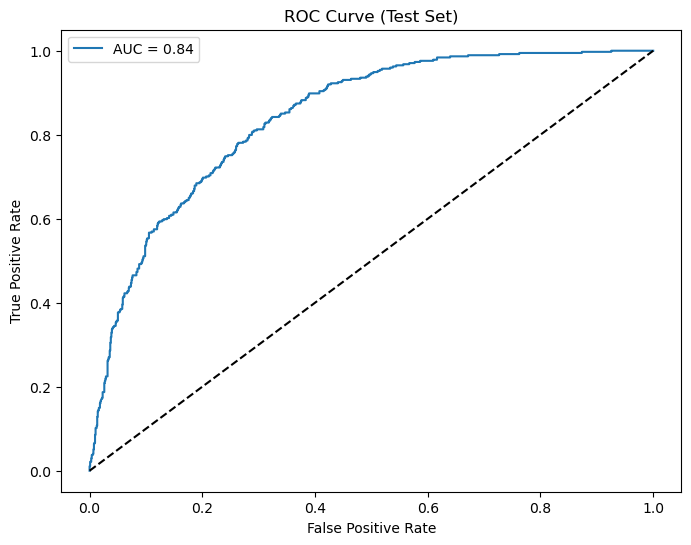

In [10]:

# Calculate FPR, TPR and decision threshold
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
auc_score = roc_auc_score(y_test, test_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend()
plt.show()

An ideal ROC curve should have greater true positives than false positives which is why the diagonal line is inserted on the plot. Below the diagonal indicates a greater FPR than TPR which is a sign of a poor performing model.

## Analysis

**Discuss the performance of your model, especially with regards to the test set.** 

The logistic regression model is adequate in predicting class 0 (no churn) due its support. The support for class 1 is about one-third that of class 0 so this is a major reason for the imbalance in the dataset. With precision equal to .66, the model does a fair job in avoiding wrong classifications of class 1; however, it performs much better on class 0 with precision equalling .85.

We see a similar weakness of the logistic regression model in classifying actual customers who churn with a recall value of .57. While the model generally avoids false alarms for class 1, the low recall indicates a significant problem at identifying customers with imminent risk of leaving.

**Use your confusion matrix and ROC score to reason about how Acme can best apply its incentives to keep the most profitable customers. Note that while all parts of your work on this project are important, this is the part that senior management is most likely to read.**



Looking at the bottom row of the confusion matrix, Acme should start to allocate retention incentives to the top 30% of predicted churners. Precision of .66 emphasizes the cost of false negatives for class 1. In this case our model incorrectly classifies 162 churners which is a lot when comparing class support. 

The precision score complement (1 minus precision) should give us an idea of the incentives required because precision is a measure of irrelevancy in class predictions avoided by the ML algorithm. A perfect logistic regression model for this classification problem should always avoid misclassifications of class 1. 

## Conclusion

**Briefly summarize what you accomplished in this lab in terms of the imagined data analytics problem?** 

I applied a logistic regression approach to this classification data analytics problem in predicting customer churn probability at Acme. After plotting an ROC curve to evaluate tradeoff between hit rate and false alarms in the dataset, I began to gain some intuition that the model is performing poorly on what Acme actual cares about: customers at risk of churning.

The data imbalance doesn't make the search for a probabilistic solution any easi.  Although we arrived at a high AUC score of .84, this is heavily biased due to the ignorance of class distribution and error costser. Hence, given the poor recall value of .57 for class 1, Acme should look to towards developing incentives for customers in the near future.

**Briefly summarize what *you* learned in this lab.**

The major thing leaened is that a frequentist approach to probability will almost always be biased. With morand more e data collated foar ny experiment, you would expe t your chances of learning an approximate functiofor s your target variabltoto increase. However, there could be problems with the data collation procedulwhich canld lead ly poopredictionse
l
lAlso in the case of a heavily imbalanced dataset, , one cannot quantify how missing data negatively influence the predictive performance othe a logistic regression melod. It could have been less prone to fitting over noise if we had a valid TotalCharges feates..*


## References

**Indicate any helpful references other than slides, notes, or examples given in class.**

https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

https://www.google.com/search?q=how+to+impute+on+missing+values+in+column+with+its+median+group+by+another+jupyter&sca_esv=830a0b600f7af676&sxsrf=AHTn8zrq6h-TB2JajlBVDlGve2VdlonqSg%3A1742483786879&ei=SjHcZ-OXNfP_ptQP2fzZsQo&ved=0ahUKEwjj5JL5-ZiMAxXzv4kEHVl-NqYQ4dUDCBI&uact=5&oq=how+to+impute+on+missing+values+in+column+with+its+median+group+by+another+jupyter&gs_lp=Egxnd3Mtd2l6LXNlcnAiUmhvdyB0byBpbXB1dGUgb24gbWlzc2luZyB2YWx1ZXMgaW4gY29sdW1uIHdpdGggaXRzIG1lZGlhbiBncm91cCBieSBhbm90aGVyIGp1cHl0ZXJIu8oDUP4FWKzJA3ACeACQAQKYAcQBoAGrHqoBBTE3LjE5uAEDyAEA-AEBmAIBoAJqwgIEECEYCpgDAIgGAZIHAzAuMaAHmi6yBwMwLjG4B2o&sclient=gws-wiz-serp


https://www.google.com/search?q=how+to+encode+select+datatypes+jupyter&oq=how+to+encode+select+datatypes+jupyter&gs_lcrp=EgZjaHJvbWUyCQgAEEUYORifBdIBCTEyMTQxajBqN6gCALACAA&sourceid=chrome&ie=UTF-8
https://www.nb-data.com/p/breaking-down-the-classification




https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html


https://www.google.com/search?q=how+to+plot+roc+confusion+matrix+jupyter+&sca_esv=a9287b5cf37d50af&sxsrf=AHTn8zrjTwR_EHnOt3hox9QUiDvxh0XXBg%3A1742435288630&ei=2HPbZ8OQJobHp84PveS5yQo&ved=0ahUKEwjD3LCjxZeMAxWG48kDHT1yLqkQ4dUDCBI&uact=5&oq=how+to+plot+roc+confusion+matrix+jupyter+&gs_lp=Egxnd3Mtd2l6LXNlcnAiKWhvdyB0byBwbG90IHJvYyBjb25mdXNpb24gbWF0cml4IGp1cHl0ZXIgMgUQIRigATIFECEYoAFIoCdQ-QNY-CNwAXgBkAEAmAHiAaABhhGqAQUwLjYuNbgBA8gBAPgBAZgCBqACgwjCAgoQABiwAxjWBBhHwgIEECMYJ8ICBhAAGBYYHsICCxAAGIAEGIYDGIoFwgIIEAAYogQYiQXCAggQABiABBiiBJgDAIgGAZAGCJIHBTEuNC4xoAfBI7IHBTAuNC4xuAf8Bw&sclient=gws-wiz-serp


